<a href="https://colab.research.google.com/github/subho99/Computational-Data-Science/blob/main/SubhajitBasistha_M5_NB_MiniProject_2_Simple_Analytics_Pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Simple Analytics using Pyspark

## Problem Statement

Perform simple analytics with Pyspark on the real estate valuation dataset and predict the house price per unit area

## Learning Objectives

At the end of the mini-project, you will be able to :

* analyze the data using pyspark
* derive the insights and visualize the data
* implement linear regression and evaluate using pyspark

### Dataset

The dataset chosen for this mini-project is **Real Estate Valuation dataset**. The data was collected from the historical market of real estate within Sindian District of New Taipei City, the timespan across 2012 August to 2013 July. In the dataset, the response variable (house price per unit area) is calculated in a local unit which is approximately $10000 New Taipei Dollar per 3.3 squared meters. For the collection of regressor data, the transaction dates are transformed into a format such that 2013.250 = 2013 March, 2013.500 = 2013 June etc. The house age was collected in years and the distance to MRT stations is measured in meters.

**Reference:**
The original owner of this Real Estate Valuation dataset is professor I-Cheng Yeh from TamKang University (Department of Civil Engineering). Prof. Yeh donated this dataset to UCI machine learning repository on 18th August 2018. The dataset can be accessed at https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set#[1].

## Grading = 10 Points

#### Install Pyspark

In [1]:
#@title Install pyspark and Download the data
!pip -qq install pyspark
!pip -qq install handyspark
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/RealEstate.csv
print("Packages installed and dataset downloaded successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Packages installed and dataset downloaded successfully!


#### Import required packages

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, floor, round
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import MinMaxScaler
from handyspark import *
import seaborn as sns
from matplotlib import pyplot as plt

### Data Loading (1 point)

#### Start a Spark Session

Spark session is a combined entry point of a Spark application, which came into implementation from Spark 2.0. It provides a way to interact with various spark’s functionality with a lesser number of constructs.

In [4]:
spark = SparkSession.builder.appName('RealEstate').getOrCreate()

#### Load the data and infer the schema

To load the dataset use the `read.csv` with `inferSchema` and `header` as parameters.

In [6]:
csv_path = "/content/RealEstate.csv"
real_estate_dataset = spark.read.csv(csv_path,inferSchema=True,header=True)
real_estate_dataset.show()

+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
| No|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
|  1|           2012.917|        32.0|                              84.87882|                             10|   24.98298|   121.54024|                      37.9|
|  2|           2012.917|        19.5|                              306.5947|                              9|   24.98034|   121.53951|                      42.2|
|  3|           2013.583|        13.3|                              561.9845|                              5|   24.98746|   121.54391|                      47.3|
|  4|             2013.5|   

In [7]:
real_estate_dataset.dtypes

[('No', 'int'),
 ('X1 transaction date', 'double'),
 ('X2 house age', 'double'),
 ('X3 distance to the nearest MRT station', 'double'),
 ('X4 number of convenience stores', 'int'),
 ('X5 latitude', 'double'),
 ('X6 longitude', 'double'),
 ('Y house price of unit area', 'double')]

In [8]:
real_estate_dataset.printSchema()

root
 |-- No: integer (nullable = true)
 |-- X1 transaction date: double (nullable = true)
 |-- X2 house age: double (nullable = true)
 |-- X3 distance to the nearest MRT station: double (nullable = true)
 |-- X4 number of convenience stores: integer (nullable = true)
 |-- X5 latitude: double (nullable = true)
 |-- X6 longitude: double (nullable = true)
 |-- Y house price of unit area: double (nullable = true)



In [9]:
real_estate_dataset.columns

['No',
 'X1 transaction date',
 'X2 house age',
 'X3 distance to the nearest MRT station',
 'X4 number of convenience stores',
 'X5 latitude',
 'X6 longitude',
 'Y house price of unit area']

#### Fetch the data using handyspark

* Create a HandyFrame using handyspark `toHandy()` function

* using an instance of `cols` from your HandyFrame, you can retrieve values for given columns in the top N rows

Hint: [toHandy()](https://dvgodoy.github.io/handyspark/includeme.html)

In [10]:
hdf = real_estate_dataset.toHandy()
hdf

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


HandyFrame[No: int, X1 transaction date: double, X2 house age: double, X3 distance to the nearest MRT station: double, X4 number of convenience stores: int, X5 latitude: double, X6 longitude: double, Y house price of unit area: double]

In [11]:
N = 5
hdf.cols[['No', 'X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station',
         'X4 number of convenience stores', 'X5 latitude', 'X6 longitude', 'Y house price of unit area']][:N]

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [12]:
print("Transaction date wise value counts:\n", hdf.cols['X1 transaction date'].value_counts(dropna=False))
print("House age wise value counts:\n", hdf.cols['X2 house age'].value_counts(dropna=False))
print("Distance to the nearest MRT station wise value counts:\n", hdf.cols['X3 distance to the nearest MRT station'].value_counts(dropna=False))
print("No. of convenience stores wise value counts:\n", hdf.cols['X4 number of convenience stores'].value_counts(dropna=False))
print("Latitude wise value counts:\n", hdf.cols['X5 latitude'].value_counts(dropna=False))
print("Longitude wise value counts:\n", hdf.cols['X6 longitude'].value_counts(dropna=False))
print("House price of unit area wise value counts:\n", hdf.cols['Y house price of unit area'].value_counts(dropna=False))

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


Transaction date wise value counts:
 X1 transaction date
2012.667    30
2012.750    27
2012.833    31
2012.917    38
2013.000    28
2013.083    46
2013.167    25
2013.250    32
2013.333    29
2013.417    58
2013.500    47
2013.583    23
Name: value_counts, dtype: int64


/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


House age wise value counts:
 X2 house age
0.0     17
1.0      1
1.1      5
1.5      2
1.7      1
        ..
40.9     2
41.3     2
41.4     1
42.7     1
43.8     1
Name: value_counts, Length: 236, dtype: int64


/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


Distance to the nearest MRT station wise value counts:
 X3 distance to the nearest MRT station
23.38284      2
49.66105      2
56.47425      3
57.58945      1
82.88643      1
             ..
4605.74900    1
5512.03800    2
6306.15300    1
6396.28300    1
6488.02100    1
Name: value_counts, Length: 259, dtype: int64


/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


No. of convenience stores wise value counts:
 X4 number of convenience stores
0     67
1     46
2     24
3     46
4     31
5     67
6     37
7     31
8     30
9     25
10    10
Name: value_counts, dtype: int64


/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


Latitude wise value counts:
 X5 latitude
24.93207    1
24.93293    1
24.93363    1
24.93885    3
24.94155    7
           ..
24.99156    2
24.99176    2
24.99800    1
25.00115    1
25.01459    1
Name: value_counts, Length: 234, dtype: int64


/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


Longitude wise value counts:
 X6 longitude
121.47353    1
121.47516    1
121.47883    1
121.48458    2
121.49507    1
            ..
121.55391    1
121.55481    1
121.55964    2
121.56174    1
121.56627    2
Name: value_counts, Length: 232, dtype: int64


/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


House price of unit area wise value counts:
 Y house price of unit area
7.6      1
11.2     1
11.6     1
12.2     1
12.8     2
        ..
71.0     1
73.6     1
78.0     1
78.3     1
117.5    1
Name: value_counts, Length: 270, dtype: int64


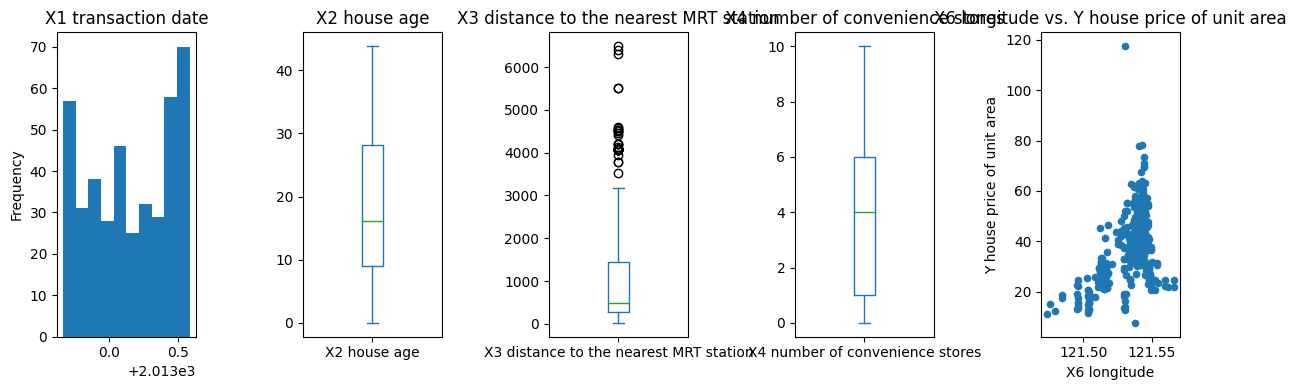

In [13]:
# Converting the PySpark DataFrame to Pandas DataFrame for easy plotting
hdf_pandas = real_estate_dataset.toPandas()

N = 5
fig, axs = plt.subplots(1, 5, figsize=(12, 4))

# Plotting histogram using pandas directly
hdf_pandas['X1 transaction date'].plot(kind='hist', ax=axs[0])
axs[0].set_title('X1 transaction date')

# Plotting boxplot using pandas directly
hdf_pandas['X2 house age'].plot(kind='box', ax=axs[1])
axs[1].set_title('X2 house age')

hdf_pandas['X3 distance to the nearest MRT station'].plot(kind='box', ax=axs[2])
axs[2].set_title('X3 distance to the nearest MRT station')

hdf_pandas['X4 number of convenience stores'].plot(kind='box', ax=axs[3])
axs[3].set_title('X4 number of convenience stores')

# Scatter plot using pandas directly
hdf_pandas.plot(kind='scatter', x='X6 longitude', y='Y house price of unit area', ax=axs[4])
axs[4].set_title('X6 longitude vs. Y house price of unit area')

plt.tight_layout()
plt.show()

In [14]:
hdf.cols[['X6 longitude', 'Y house price of unit area']][:5]

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


,X6 longitude,Y house price of unit area
0,121.54024,37.9
1,121.53951,42.2
2,121.54391,47.3
3,121.54391,54.8
4,121.54245,43.1


### Deriving the insights (2 points)

#### show the no. of records per month

Hint: Apply [groupby](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.GroupedData.agg.html?highlight=agg#pyspark.sql.GroupedData.agg) on transaction date and count the records using aggregation `agg()`

In [15]:
real_estate_dataset.select('X1 transaction date').groupby('X1 transaction date').agg(count('X1 transaction date')).show()

+-------------------+--------------------------+
|X1 transaction date|count(X1 transaction date)|
+-------------------+--------------------------+
|            2012.75|                        27|
|           2013.333|                        29|
|           2013.083|                        46|
|           2012.833|                        31|
|             2013.5|                        47|
|           2013.583|                        23|
|           2013.417|                        58|
|           2013.167|                        25|
|            2013.25|                        32|
|             2013.0|                        28|
|           2012.917|                        38|
|           2012.667|                        30|
+-------------------+--------------------------+



#### how much is the increase in the average house price in 2012 to 2013

Hint: Apply [filter](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.filter.html) on the transaction date and aggregate the house price using mean

In [16]:
from pyspark.sql import functions as F
rtran_dt_2012 = real_estate_dataset.filter(col('X1 transaction date') < 2013)
rtran_agg_2012 = rtran_dt_2012.agg(F.mean('Y house price of unit area').alias('mean_price_2012'))
rtran_agg_2012.show()

+------------------+
|   mean_price_2012|
+------------------+
|36.304761904761904|
+------------------+



In [17]:
rtran_dt_2013 = real_estate_dataset.filter(col('X1 transaction date') >= 2013)
rtran_agg_2013 = rtran_dt_2013.agg(F.mean('Y house price of unit area').alias('mean_price_2013'))
rtran_agg_2013.show()

+------------------+
|   mean_price_2013|
+------------------+
|38.713194444444454|
+------------------+



In [18]:
# Extracting the mean values as scalars
mean_price_2012 = rtran_agg_2012.collect()[0]['mean_price_2012']
mean_price_2013 = rtran_agg_2013.collect()[0]['mean_price_2013']

# Calculating the increment in price
increment_in_price = mean_price_2013 - mean_price_2012

# Displaying the result
print("Increment in average house price:", increment_in_price)

Increment in average house price: 2.4084325396825506


#### Find the count of houses with no convenience store and show the top 10 records

In [19]:
# Filtering the DataFrame to select houses with no convenience store (X4 number of convenience stores = 0)
houses_with_no_convenience_store = real_estate_dataset.filter(col('X4 number of convenience stores') == 0)

# Getting the count of houses with no convenience store
count_of_houses_with_no_convenience_store = houses_with_no_convenience_store.count()

# Displaying the count
print("Count of houses with no convenience store:", count_of_houses_with_no_convenience_store)

# Showing the top 10 records
houses_with_no_convenience_store.show(10)

Count of houses with no convenience store: 67
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
| No|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
| 31|             2013.5|        25.9|                               4519.69|                              0|   24.94826|   121.49587|                      22.1|
| 36|             2013.5|        13.9|                              4079.418|                              0|   25.01459|   121.51816|                      27.3|
| 41|             2013.0|        13.6|                              4082.015|                              0|   24.94155|   121.50381|          

#### Compare the maximum price of houses *with convenient store* and *without convenience store*

In [20]:
from pyspark.sql import functions as F
# Filtering the DataFrame to select houses with and without convenience store
houses_with_convenience_store = real_estate_dataset.filter(col('X4 number of convenience stores') > 0)
houses_without_convenience_store = real_estate_dataset.filter(col('X4 number of convenience stores') == 0)

# Calculating the maximum price for houses with and without convenience store
max_price_with_convenience_store_df = houses_with_convenience_store.agg(F.max('Y house price of unit area')) #DataFrame[max(Y house price of unit area): double]
max_price_with_convenience_store_df = max_price_with_convenience_store_df.collect()
max_price_with_convenience_store = max_price_with_convenience_store_df[0][0]

max_price_without_convenience_store_df = houses_without_convenience_store.agg(F.max('Y house price of unit area'))
max_price_without_convenience_store_df = max_price_without_convenience_store_df.collect()
max_price_without_convenience_store = max_price_without_convenience_store_df[0][0]

# Displaying the results
print("Maximum price of houses with convenience store:", max_price_with_convenience_store)
print("Maximum price of houses without convenience store:", max_price_without_convenience_store)

Maximum price of houses with convenience store: 117.5
Maximum price of houses without convenience store: 55.3


#### Decode the transaction date

* create a year column separately by removing the decimal places from transaction date column

    Hint: `withColumn()`

* create a month column separately based on the decimal places from the transaction date column

 **Hints:** multiply decimal place number with 12 and apply round off, perform below steps
     
     - use `udf()` from pyspark
     - subtracting `transaction date` from `int(transaction date)` will give the decimal place number
     - multiply the result with 12 and roundoff

To know more about udf(), click [here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.udf.html?highlight=udf#pyspark.sql.functions.udf)

In [21]:
# Creating a year column by removing the decimal places from the transaction date column
real_estate_dataset_with_year = real_estate_dataset.withColumn("Year", floor(col("X1 transaction date")))

# Showing the DataFrame with the new 'Year' column
real_estate_dataset_with_year.show()

+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+----+
| No|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|Year|
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+----+
|  1|           2012.917|        32.0|                              84.87882|                             10|   24.98298|   121.54024|                      37.9|2012|
|  2|           2012.917|        19.5|                              306.5947|                              9|   24.98034|   121.53951|                      42.2|2012|
|  3|           2013.583|        13.3|                              561.9845|                              5|   24.98746|   121.54391|                      47.3|2013

In [22]:
# Defining a UDF to extract the decimal places from the transaction date and calculate the month
def calculate_month(transaction_date):
    decimal_place = transaction_date - int(transaction_date)
    return decimal_place * 12

# Registering the UDF with Spark
calculate_month_udf = udf(calculate_month)

# Creating a month column by applying the UDF to the 'X1 transaction date' column
real_estate_dataset_with_yr_month = real_estate_dataset_with_year.withColumn("Month", round(calculate_month_udf(col("X1 transaction date"))).cast('int'))

# Showing the DataFrame with the new 'Month' column
real_estate_dataset_with_yr_month.show()

+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+----+-----+
| No|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|Year|Month|
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+----+-----+
|  1|           2012.917|        32.0|                              84.87882|                             10|   24.98298|   121.54024|                      37.9|2012|   11|
|  2|           2012.917|        19.5|                              306.5947|                              9|   24.98034|   121.53951|                      42.2|2012|   11|
|  3|           2013.583|        13.3|                              561.9845|                              5|   24.98746|   121.54391| 

### Data Visualization (2 points)

#### Select the continuous variables from the data and visualize using histogram

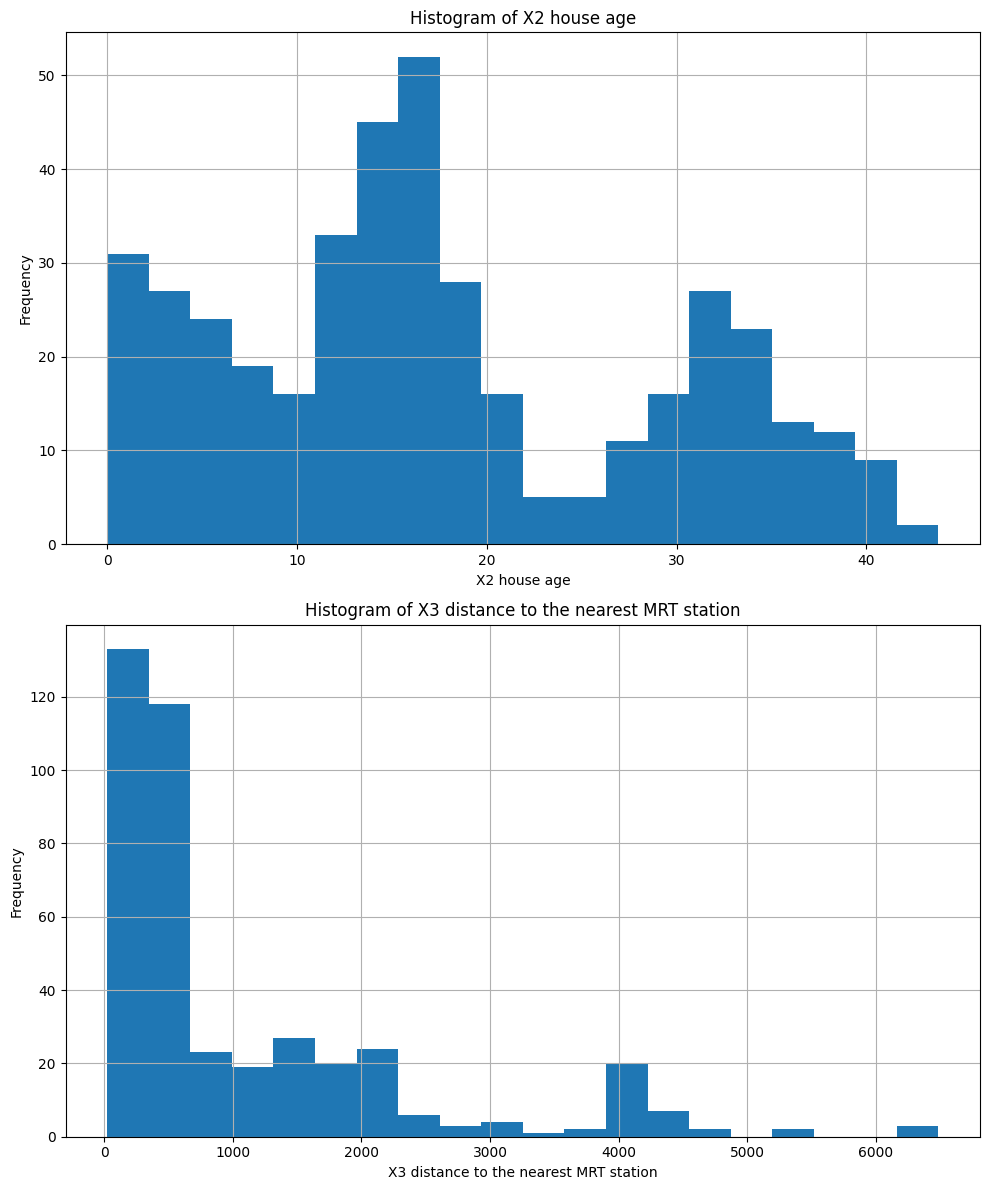

In [23]:
import matplotlib.pyplot as plt

# Selecting the continuous variables for histogram visualization
continuous_variables = ['X2 house age', 'X3 distance to the nearest MRT station']

# Plotting histograms for the selected continuous variables
fig, axs = plt.subplots(len(continuous_variables), figsize=(10, 6 * len(continuous_variables)))
for i, variable in enumerate(continuous_variables):
    real_estate_dataset.select(variable).toPandas().hist(ax=axs[i], bins=20)
    axs[i].set_title(f"Histogram of {variable}")
    axs[i].set_xlabel(variable)
    axs[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")



INFO: Safety is ON - returning up to 1000 instances.


array([[<Axes: title={'center': 'X2 house age'}>,
        <Axes: title={'center': 'X3 distance to the nearest MRT station'}>]],
      dtype=object)

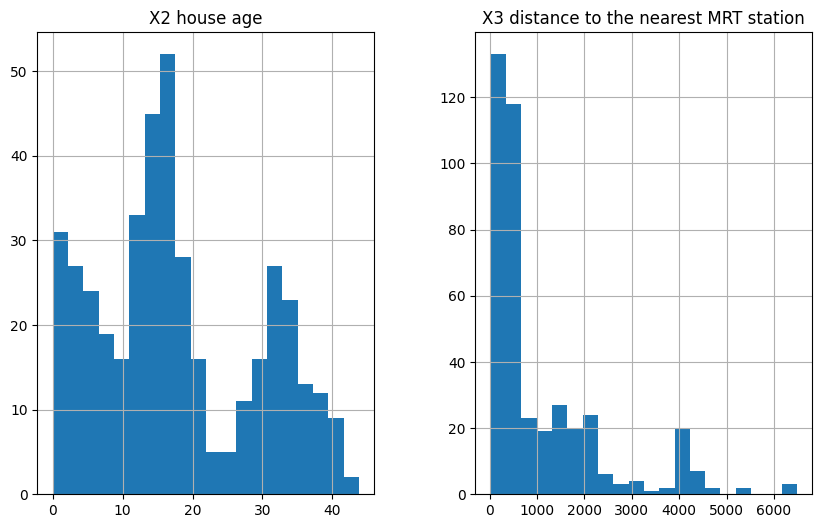

In [24]:
hdf_cols = hdf.cols[['X2 house age','X3 distance to the nearest MRT station']][:]
hdf_cols.hist(bins=20,figsize=(10, 6))

#### Visualize the transaction date using the countplot

+-------------------+--------------------------+
|X1 transaction date|count(X1 transaction date)|
+-------------------+--------------------------+
|            2012.75|                        27|
|           2013.333|                        29|
|           2013.083|                        46|
|           2012.833|                        31|
|             2013.5|                        47|
|           2013.583|                        23|
|           2013.417|                        58|
|           2013.167|                        25|
|            2013.25|                        32|
|             2013.0|                        28|
|           2012.917|                        38|
|           2012.667|                        30|
+-------------------+--------------------------+



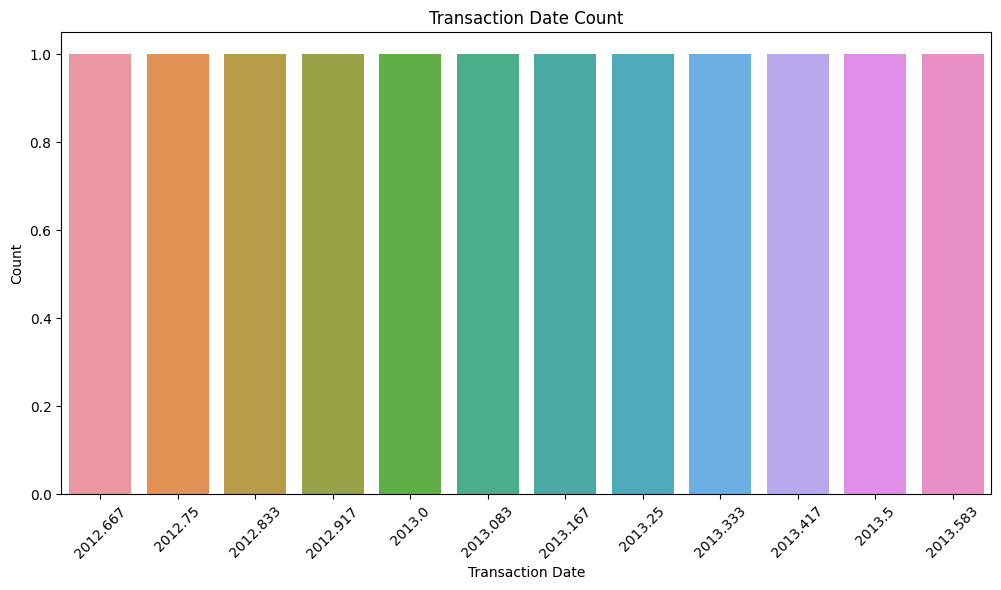

In [25]:
# Performing groupBy and count operations on the Spark DataFrame
transaction_date_counts = real_estate_dataset.select('X1 transaction date').groupby('X1 transaction date').agg(count('X1 transaction date'))
transaction_date_counts.show()
# Converting the result to a Pandas DataFrame for visualization
transaction_date_counts_pandas = transaction_date_counts.toPandas()
transaction_date_counts_pandas.head()

# Plotting the countplot using Seaborn
plt.figure(figsize=(12, 6))
sns.countplot(data=transaction_date_counts_pandas, x='X1 transaction date')
plt.title("Transaction Date Count")
plt.xlabel("Transaction Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [26]:
transaction_date_counts_pandas.iloc[:,1]

0     27
1     29
2     46
3     31
4     47
5     23
6     58
7     25
8     32
9     28
10    38
11    30
Name: count(X1 transaction date), dtype: int64

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")



INFO: Safety is ON - returning up to 1000 instances.


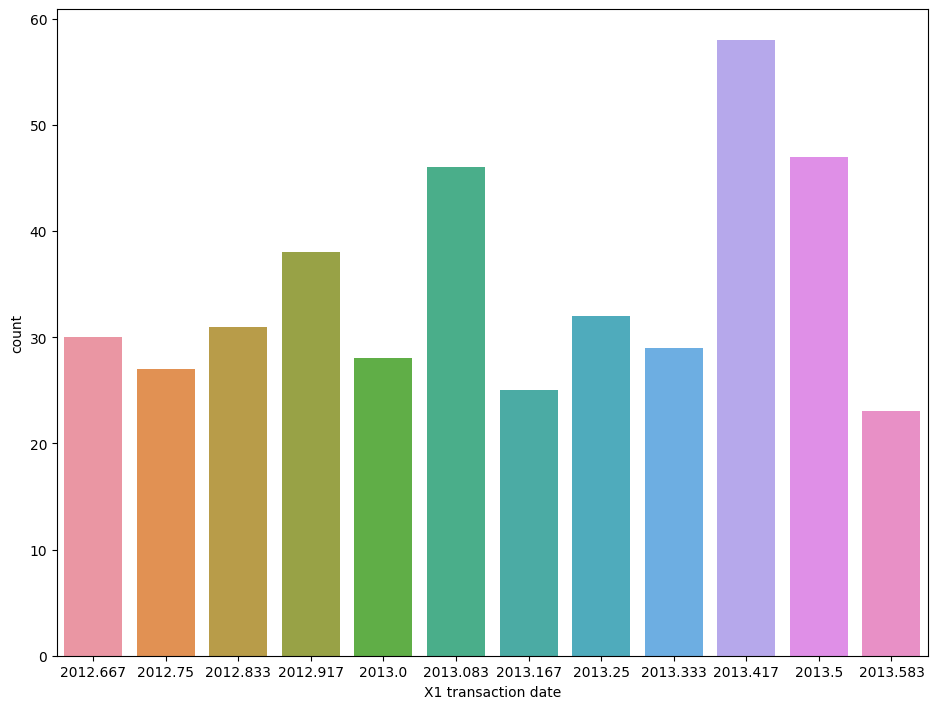

In [27]:
hdf_tran = hdf.cols[['X1 transaction date', 'X3 distance to the nearest MRT station']][:]
sns.countplot(x = 'X1 transaction date', data = hdf_tran)
plt.tight_layout(rect=(0, 0, 1.5, 1.5))

#### visualize number of convenience stores with appropriate plot.

In [28]:
house_with_conv_stores_counts = real_estate_dataset.select('X4 number of convenience stores').groupby('X4 number of convenience stores').agg(count('X4 number of convenience stores'))
house_with_conv_stores_counts.show()
# Converting the result to a Pandas DataFrame for visualization
house_with_conv_stores_counts_pandas = house_with_conv_stores_counts.toPandas()
house_with_conv_stores_counts_pandas.head()

+-------------------------------+--------------------------------------+
|X4 number of convenience stores|count(X4 number of convenience stores)|
+-------------------------------+--------------------------------------+
|                              1|                                    46|
|                              6|                                    37|
|                              3|                                    46|
|                              5|                                    67|
|                              9|                                    25|
|                              4|                                    31|
|                              8|                                    30|
|                              7|                                    31|
|                             10|                                    10|
|                              2|                                    24|
|                              0|                  

,X4 number of convenience stores,count(X4 number of convenience stores)
0,1,46
1,6,37
2,3,46
3,5,67
4,9,25


/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")



INFO: Safety is ON - returning up to 1000 instances.


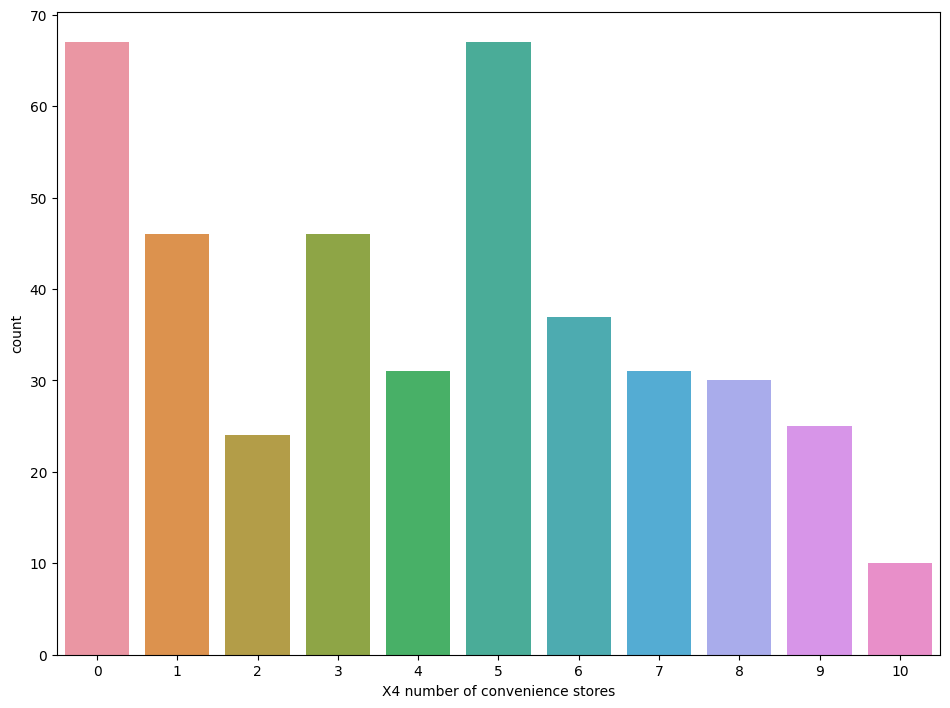

In [29]:
hdf_conv_stores = hdf.cols[['X4 number of convenience stores']][:]
sns.countplot(x = 'X4 number of convenience stores', data = hdf_conv_stores)
plt.tight_layout(rect=(0, 0, 1.5, 1.5))

#### visualize the geographical distribution of the house prices of unit area

With:

* x-axis = X6 longitude
* y-axis = X5 latitude
* datapoints = Y house price of unit area
* parameters including size `s` and color map `cmap`

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")



INFO: Safety is ON - returning up to 1000 instances.


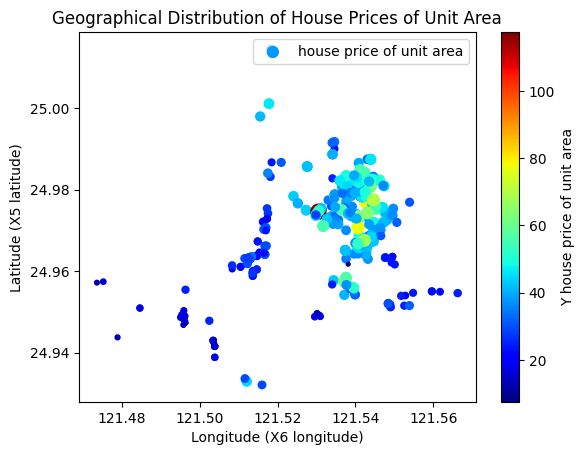

In [30]:
# Selecting the required columns for plotting
hdf_lat_long_housePrice = hdf.cols[['Y house price of unit area', 'X6 longitude', 'X5 latitude']][:]


# Plotting the geographical distribution using HandyFrame's plot function
scatterplot = hdf_lat_long_housePrice.plot(
    kind='scatter',
    x='X6 longitude',
    y='X5 latitude',
    s=hdf_lat_long_housePrice['Y house price of unit area'].to_list(),
    label="house price of unit area",
    c='Y house price of unit area',
    cmap='jet',
    colorbar=True,
    legend='brief',
    title="Geographical Distribution of House Prices of Unit Area",
    xlabel="Longitude (X6 longitude)",
    ylabel="Latitude (X5 latitude)"
)

#scatterplot.colorbar.set_label("House Price of Unit Area")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


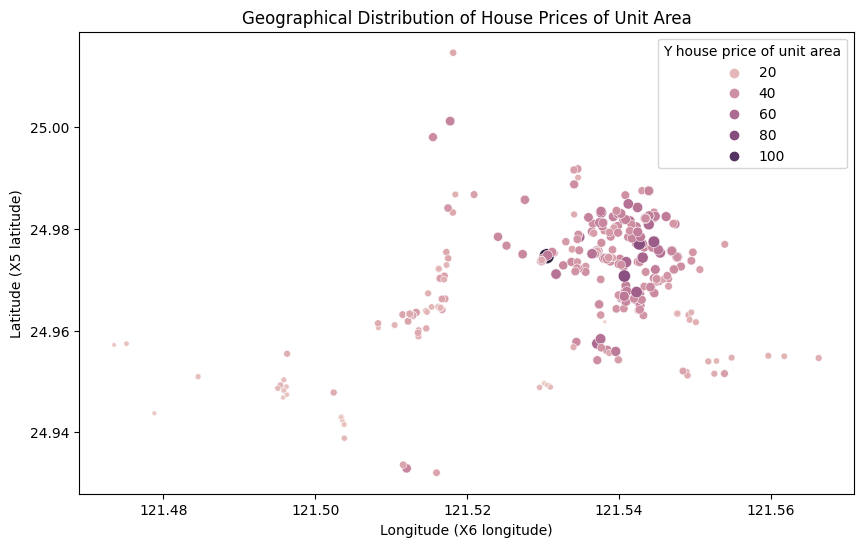

In [31]:
# Plotting the geographical distribution using seaborn scatterplot
plt.figure(figsize=(10, 6))
scatterplot = sns.scatterplot(data=hdf_lat_long_housePrice, x='X6 longitude', y='X5 latitude',
                s=hdf_lat_long_housePrice['Y house price of unit area'].to_list(),
                sizes=(20, 200), cmap='jet', hue='Y house price of unit area', legend='brief')
plt.title("Geographical Distribution of House Prices of Unit Area")
plt.xlabel("Longitude (X6 longitude)")
plt.ylabel("Latitude (X5 latitude)")

plt.show()

### Feature Scaling (1 point)

#### Identify the outliers

Use the pairplot or boxplot to identify the outliers

   **Hint:** `sns.pairplot`

In [32]:
real_estate_cols = real_estate_dataset_with_yr_month.columns[0:8]
real_estate_cols

['No',
 'X1 transaction date',
 'X2 house age',
 'X3 distance to the nearest MRT station',
 'X4 number of convenience stores',
 'X5 latitude',
 'X6 longitude',
 'Y house price of unit area']

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")



INFO: Safety is ON - returning up to 1000 instances.


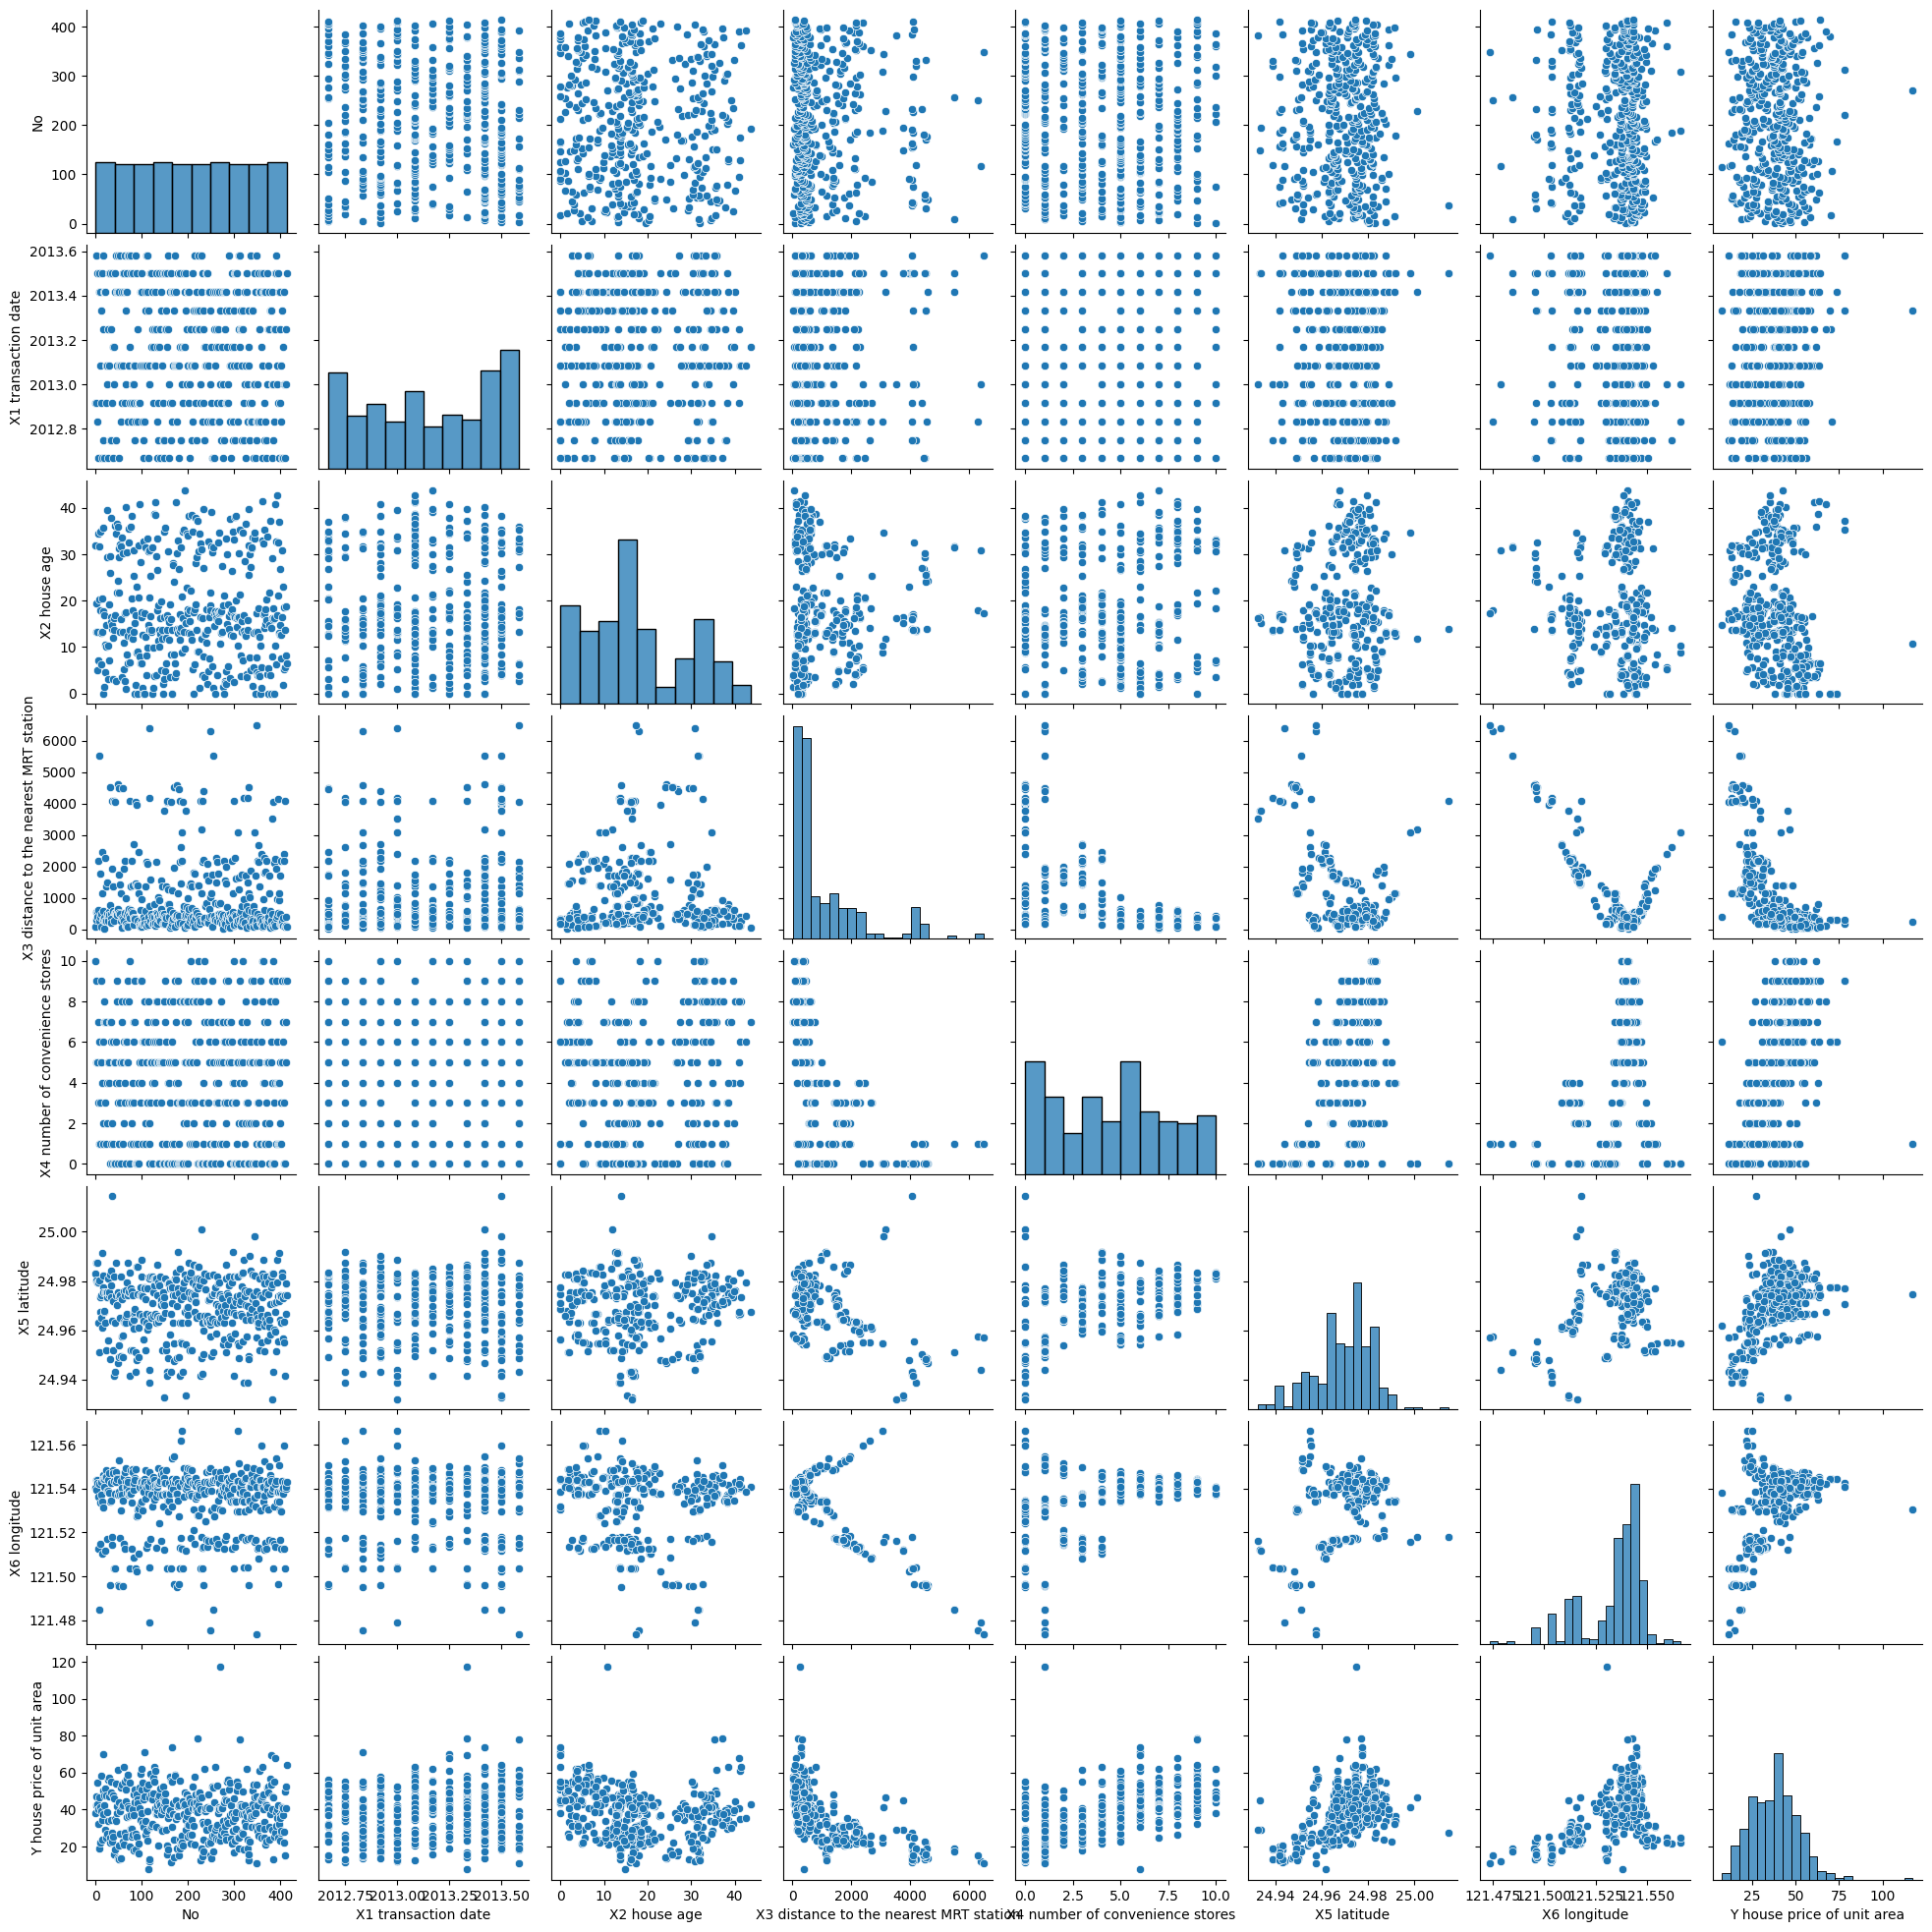

In [33]:
import seaborn as sns
# Selecting the continuous variables from the HandyFrame
hdf_continuous = hdf.cols[real_estate_cols][:]

# Creating a pair plot to visualize the distribution and identify outliers
sns.pairplot(hdf_continuous)
plt.show()

#### Correlation analysis

create the correlation matrix of all the columns and visualize using the heatmap

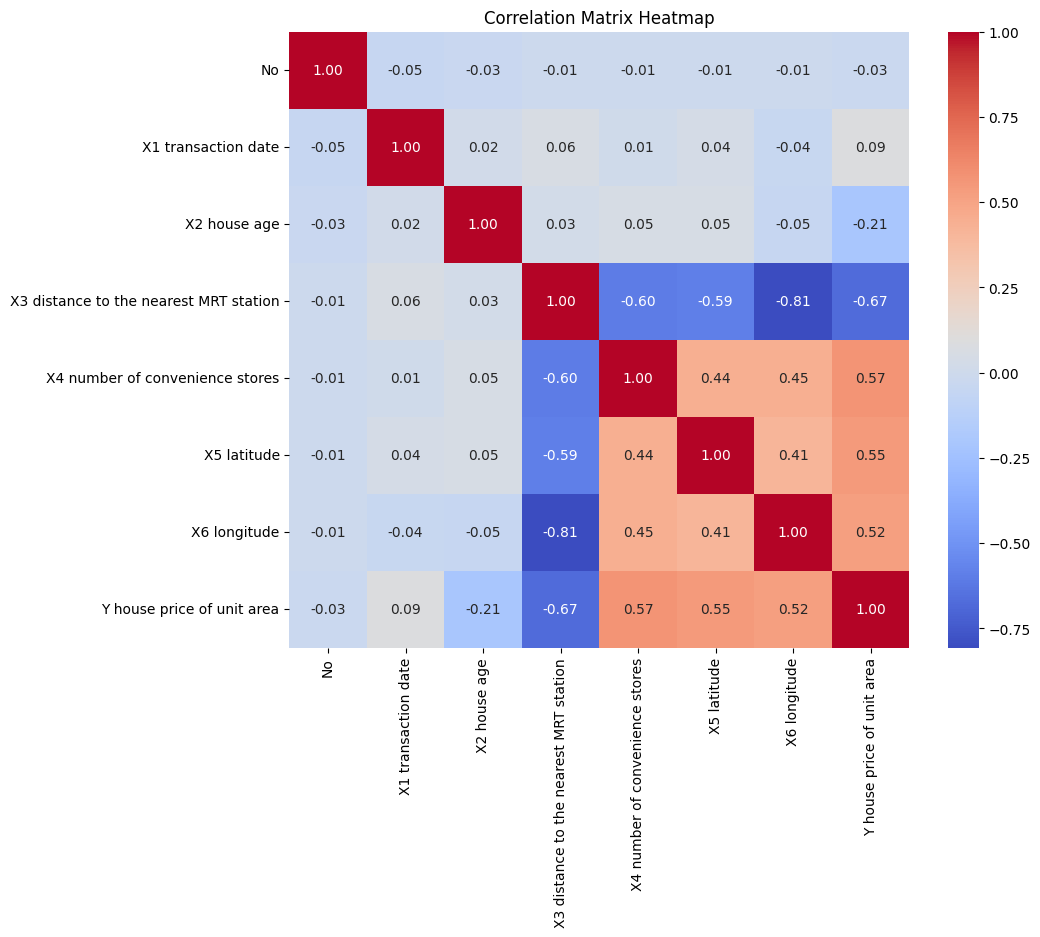

In [34]:
# Calculating the correlation matrix
correlation_matrix = hdf_continuous.corr()

# Creating a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

#### Normalization or standardization

select the applicable features using vector assembler and apply scaling using `MinMaxScaler` from pyspark

Hint: [MinMaxScaler](https://spark.apache.org/docs/latest/ml-features#minmaxscaler)

In [35]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline


# Selecting the applicable features
inputCols = ['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores']
outputCol = 'features'

# Creating the VectorAssembler
vector_assembler = VectorAssembler(inputCols=inputCols, outputCol=outputCol)

# Creating the MinMaxScaler
min_max_scaler = MinMaxScaler(inputCol=outputCol, outputCol="scaled_features")

# Creating the pipeline
pipeline = Pipeline(stages=[vector_assembler, min_max_scaler])

# Applying the PySpark pipeline to the DataFrame
scaled_dataset = pipeline.fit(real_estate_dataset_with_yr_month).transform(real_estate_dataset_with_yr_month)

# Showing the scaled DataFrame
scaled_dataset.show()

+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+----+-----+--------------------+--------------------+
| No|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|Year|Month|            features|     scaled_features|
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+----+-----+--------------------+--------------------+
|  1|           2012.917|        32.0|                              84.87882|                             10|   24.98298|   121.54024|                      37.9|2012|   11|[32.0,84.87882,10.0]|[0.73059360730593...|
|  2|           2012.917|        19.5|                              306.5947|                              9|   24.98034|   121.53951|      

In [36]:
scaled_dataset.select("scaled_features").show(20, truncate= False)

+-------------------------------------------------------------+
|scaled_features                                              |
+-------------------------------------------------------------+
|[0.7305936073059361,0.00951267162646579,1.0]                 |
|[0.44520547945205485,0.043809390872388755,0.9]               |
|[0.30365296803652975,0.0833150513098478,0.5]                 |
|[0.30365296803652975,0.0833150513098478,0.5]                 |
|[0.11415525114155252,0.05679908927803007,0.5]                |
|[0.16210045662100458,0.3328333476285392,0.30000000000000004] |
|[0.7876712328767124,0.09282658134109707,0.7000000000000001]  |
|[0.46347031963470325,0.040871531160840725,0.6000000000000001]|
|[0.723744292237443,0.8490274357443697,0.1]                   |
|[0.408675799086758,0.2722189728867981,0.30000000000000004]   |
|[0.7945205479452055,0.05906449062572128,0.1]                 |
|[0.14383561643835618,0.010375402047250855,0.9]               |
|[0.29680365296803657,0.0725250893237928

In [37]:
# Complete dataset is represented in 12 columns
scaled_dataset.show(20)

+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+----+-----+--------------------+--------------------+
| No|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|Year|Month|            features|     scaled_features|
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+----+-----+--------------------+--------------------+
|  1|           2012.917|        32.0|                              84.87882|                             10|   24.98298|   121.54024|                      37.9|2012|   11|[32.0,84.87882,10.0]|[0.73059360730593...|
|  2|           2012.917|        19.5|                              306.5947|                              9|   24.98034|   121.53951|      

### Feature Engineering (2 points)

#### Assemble the features

concatenate all the features into a single vector which can be further passed to the ML algorithm.

**Hint:** `VectorAssembler()`

In [38]:
vector_assembler_feature_engg = VectorAssembler(inputCols=['Year','Month','scaled_features','X5 latitude','X6 longitude'],
                                   outputCol='final_features')
scaled_dataset.dtypes

[('No', 'int'),
 ('X1 transaction date', 'double'),
 ('X2 house age', 'double'),
 ('X3 distance to the nearest MRT station', 'double'),
 ('X4 number of convenience stores', 'int'),
 ('X5 latitude', 'double'),
 ('X6 longitude', 'double'),
 ('Y house price of unit area', 'double'),
 ('Year', 'bigint'),
 ('Month', 'int'),
 ('features', 'vector'),
 ('scaled_features', 'vector')]

In [39]:
output_data = vector_assembler_feature_engg.transform(scaled_dataset)
output_data.show()

+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+----+-----+--------------------+--------------------+--------------------+
| No|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|Year|Month|            features|     scaled_features|      final_features|
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+----+-----+--------------------+--------------------+--------------------+
|  1|           2012.917|        32.0|                              84.87882|                             10|   24.98298|   121.54024|                      37.9|2012|   11|[32.0,84.87882,10.0]|[0.73059360730593...|[2012.0,11.0,0.73...|
|  2|           2012.917|        19.5|                  

In [40]:
output_data.select("final_features").show(truncate=False)
print("Final columns:\n", output_data.columns)

+-------------------------------------------------------------------------------------------+
|final_features                                                                             |
+-------------------------------------------------------------------------------------------+
|[2012.0,11.0,0.7305936073059361,0.00951267162646579,1.0,24.98298,121.54024]                |
|[2012.0,11.0,0.44520547945205485,0.043809390872388755,0.9,24.98034,121.53951]              |
|[2013.0,7.0,0.30365296803652975,0.0833150513098478,0.5,24.98746,121.54391]                 |
|[2013.0,6.0,0.30365296803652975,0.0833150513098478,0.5,24.98746,121.54391]                 |
|[2012.0,10.0,0.11415525114155252,0.05679908927803007,0.5,24.97937,121.54245]               |
|[2012.0,8.0,0.16210045662100458,0.3328333476285392,0.30000000000000004,24.96305,121.51254] |
|[2012.0,8.0,0.7876712328767124,0.09282658134109707,0.7000000000000001,24.97933,121.53642]  |
|[2013.0,5.0,0.46347031963470325,0.040871531160840725,0.6000

#### Feature selection and splitting the data

In [41]:
df_final = output_data.select("final_features", "Y house price of unit area")
df_final = df_final.withColumnRenamed('Y house price of unit area','Y')
df_final.show()

+--------------------+----+
|      final_features|   Y|
+--------------------+----+
|[2012.0,11.0,0.73...|37.9|
|[2012.0,11.0,0.44...|42.2|
|[2013.0,7.0,0.303...|47.3|
|[2013.0,6.0,0.303...|54.8|
|[2012.0,10.0,0.11...|43.1|
|[2012.0,8.0,0.162...|32.1|
|[2012.0,8.0,0.787...|40.3|
|[2013.0,5.0,0.463...|46.7|
|[2013.0,6.0,0.723...|18.8|
|[2013.0,5.0,0.408...|22.1|
|[2013.0,1.0,0.794...|41.4|
|[2013.0,4.0,0.143...|58.1|
|[2012.0,11.0,0.29...|39.3|
|[2012.0,8.0,0.465...|23.8|
|[2013.0,6.0,0.301...|34.3|
|[2013.0,7.0,0.815...|50.5|
|[2013.0,3.0,0.0,0...|70.1|
|[2012.0,9.0,0.404...|37.4|
|[2013.0,5.0,0.385...|42.3|
|[2012.0,8.0,0.034...|47.7|
+--------------------+----+
only showing top 20 rows



In [42]:
# Splitting the data in Train and Test set(75% training data, 25% testing data)
train_data,test_data = df_final.randomSplit([0.75,0.25])
train_data.describe().show()
test_data.describe().show()

+-------+------------------+
|summary|                 Y|
+-------+------------------+
|  count|               316|
|   mean| 38.05537974683546|
| stddev|13.044619501946876|
|    min|               7.6|
|    max|              78.3|
+-------+------------------+

+-------+-----------------+
|summary|                Y|
+-------+-----------------+
|  count|               98|
|   mean|37.73775510204082|
| stddev|15.34912278165143|
|    min|             11.2|
|    max|            117.5|
+-------+-----------------+



### Train and Evaluate the model (2 points)

Using LinearRegression from `pyspark.ml` fit the data and find the coefficients and intercept

In [43]:
regressor = LinearRegression(featuresCol='final_features', labelCol='Y')
#Learning to fit the model from training set
model = regressor.fit(train_data)

In [44]:
# Finding the coefficients
print("The coefficients:\n", model.coefficients)

The coefficients:
 [4.461640463216405,0.2827154925740715,-11.026822636923571,-27.452712946730653,12.723155589646925,225.1497902494778,-1.9144084178203906]


In [45]:
# Finding the coefficients
print("The intercept:\n", model.intercept)

The intercept:
 -14328.762007751315


Get the predictions and show the table along with actual data and predicted data

In [46]:
predict = model.transform(test_data)
predict.select(predict.columns[:]).show(10)

+--------------------+----+------------------+
|      final_features|   Y|        prediction|
+--------------------+----+------------------+
|[2012.0,8.0,0.070...|47.7|44.570504725223145|
|[2012.0,8.0,0.130...|53.5| 50.33336516406234|
|[2012.0,8.0,0.333...|26.5|37.073609432982266|
|[2012.0,8.0,0.461...|22.8|27.711227705956844|
|[2012.0,8.0,0.465...|23.8|27.246799409982486|
|[2012.0,8.0,0.705...|39.7|45.763557496386056|
|[2012.0,8.0,0.746...|30.5|36.107481237791944|
|[2012.0,8.0,0.762...|42.2|  37.2683879494889|
|[2012.0,8.0,0.847...|31.9|  28.1893042615593|
|[2012.0,9.0,0.0,0...|45.7|  43.6557638585582|
+--------------------+----+------------------+
only showing top 10 rows



Calculate the RMSE and $R^2$ of the model

In [47]:
metrics = model.evaluate(test_data)                             # Using evaluate method we can verify our model's performance

print('Mean absolute error: {}'.format(metrics.meanAbsoluteError))
print('Root mean squared error: {}'.format(metrics.rootMeanSquaredError))
print('R_squared value: {}'.format(metrics.r2))

Mean absolute error: 6.790760823280332
Root mean squared error: 10.695704011102086
R_squared value: 0.5094243669127159
